In [149]:
import os

import rasterio
from rasterio import plot
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt
import geojson
import fiona

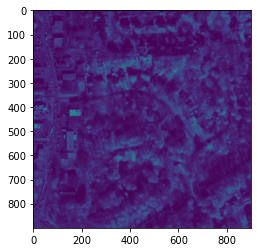

In [133]:
raster_path = "D:/SpaceNet_TrainData/train/AOI_6_Atlanta/SN4_buildings_train_AOI_6_Atlanta_nadir7_catid_1030010003D22F00_PS-RGBNIR_739451_3743589.tif"
with rasterio.open(raster_path, "r") as src:
    
    raster_img = src.read()
    raster_meta = src.meta

ds = rasterio.open(raster_path)
plt.imshow(ds.read(4))



In [136]:
shape_path = 'D:/SpaceNet_Sample/geojson/spacenet-buildings/spacenet-buildings_739451_3743589.geojson'
train_df = gpd.read_file(shape_path)
print(len(train_df))
train_df.head(5)

95


,access,addr_house,addr_hou_1,addr_inter,admin_leve,aerialway,aeroway,amenity,area,barrier,...,width,wood,z_order,tracktype,way_area,origarea,origlen,partialDec,truncated,geometry
0,,,,,,,,,,,...,,,-999999,,-999999.0,131.562923,0,0.603650,1,"POLYGON ((739896.282 3743924.944, 739899.542 3..."
1,,,,,,,,,,,...,,,-999999,,-999999.0,274.712749,0,0.597074,1,"POLYGON ((739901.000 3743931.789, 739899.557 3..."
2,,,,,,,,,,,...,,,-999999,,-999999.0,182.032147,0,1.000000,0,"POLYGON ((739612.223 3743965.297, 739624.144 3..."
3,,,,,,,,,,,...,,,-999999,,-999999.0,138.424146,0,1.000000,0,"POLYGON ((739667.564 3743962.261, 739671.148 3..."
4,,,,,,,,,,,...,,,-999999,,-999999.0,235.701235,0,1.000000,0,"POLYGON ((739695.455 3743969.477, 739700.540 3..."


In [135]:
 print("CRS Raster: {}, CRS Vector {}".format(train_df.crs, src.crs))

CRS Raster: epsg:32616, CRS Vector EPSG:32616


In [155]:
src = rasterio.open(raster_path)
with fiona.open(shape_path, 'r') as gdf:
    polys = [feature["geometry"] for feature in gdf]
    
failed = []
for num, row in train_df.iterrows():
    try:
        out_img, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        out_meta = src.meta
    except:
        failed.append(num)

    


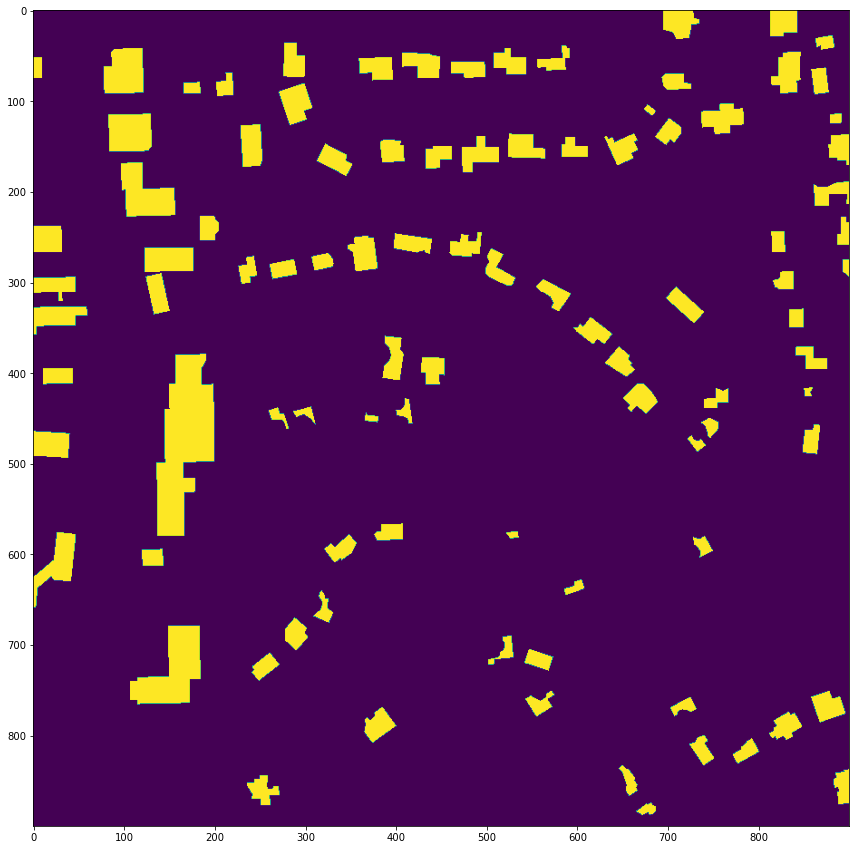

In [161]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.
poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)


# Reference
- https://medium.com/datadriveninvestor/preparing-aerial-imagery-for-crop-classification-ce05d3601c68